# The Almgren and Chriss model

In this notebook, we will implement the Almgren and Chriss model. This model is useful when we want to sell a large quantity of a stock (or of several stocks) in one day. The question is then : How to choose a good way to split this large order in time and volume ?

There are two naive strategies. The first consist in selling everything right now which leads to a huge transaction cost since we need to "eat" a lot in the order book. However this cost is known. The second consists in the day smalll amounts assets. It leads to small transaction costs (volumes are much smaller) but the final profit is unknown because of the daily price fluctuations : **volatility Risk**

We need to optimize between transaction costs and volatility risk. To do so, we use the Almgren and Chriss framework which takes into account the market impact phenomenon and emphasizes the importance of having good statistical estimators of market parameteres.

## Setup

We consider we are selling one asset. We have X shares of this assets at $T_0 = 0$. We want to everything to be sold at $t = T$. We split $[0, T]$ into $N$ intervals of length $\tau = \frac{T}{N}$ and set $t_k = k \tau, k = 0,..., N$. Atrading strategy is a vector $(x_0,...,x_N)$, with $x_k$ the number of shares we still have at time $t_k$. 

We denote $x_0 = X$, $x_N = 0$ and $n_k = x_{k-1} - x_k$ is the number of assets sold between $t_{k-1}$ and $t_k$ (and not exactly at time $t_{k-1}$ or $t_k$), decided at time $t_{k-1}$.

## Price decomposition 

The price we have access to moves because of : 
- the drift : negligeable at the intraday level
- the volatility
- the market impact

## Market impact
### Permanent market impact

Market participants see us selling large quantities. Thus they revise their prices down. Therefore, the "equilibrium price" of the asset is mopdified in a permanent way. 

If we denote $S_k$ the equilibrium price at $t_k$, then : 

$$S_k = S_{k-1} + \sigma \tau^{\frac{1}{2}} \xi_k - \tau g(n_k/\tau)$$

with $\xi_k$ iid standard Gaussian and $n_k/\tau$ the average trading rate between $t_{k-1}$ and $t_k$

The function of permanent impact is assumed to be linear : $g(n_k/\tau) = \gamma n_k/\tau$

### Temporary market impact

It is due to the transaction costs : we are liquidity taker since we consume the liquidity available in the order book. However, if we sell a large amount of shares, our price per share is significantly worse than when selling only one share. We assume this effect is temporary and the liquidity comes back after each period.

Let's denote $\widetilde{S}_k = (\sum n_{k,i}p_i)/n_k$ with $n_{k,i}$ the number of shares sold at price $p_i$ between $t_{k-1}$ and $t_k$. We then set : 

$$\widetilde{S}_k = S_{k-1} - h\left(\frac{n_k}{\tau}\right)$$

where $ h\left(\frac{n_k}{\tau}\right)$ does not influence the next equilibrium price $S_k$

The function of permanent impact is assumed to be affine : $h(n_k/\tau) = \epsilon + \eta \frac{n_k}{\tau}$

## Profit and Loss - Cost of trading 

The result of the sell of the asset is : 
$$\sum_{k=1}^{N} n_k\widetilde{S}_k = XS_0 + \sum_{k=1}^{N}(\sigma \tau^{1/2} \xi_k - \tau g(n_k/\tau))x_k - \sum_{k=1}^{N} n_kh(n_k/\tau)$$

Then the trading cost $C = XS_0 - \sum_{k=1}^{N} n_k\widetilde{S}_k$ is equal to : 

$$Vol.cost + Perm. Impact cost + Temp. Impact cost.$$

## Mean-Variance analysis

Let's consider a static strategy (fully known in $t_0$), which is in fact optimal in this framexork. We have :
$$\mathbb{E}[C] = \sum_{k=1}^{N} \tau x_k g(n_k/\tau) + \sum_{k=1}^{N} n_kh(n_k/\tau)$$
$$Var[C] = \sigma^2 \sum_{k=1}^{N}\tau x_k^2$$

In order to build optimal trading trajectories, we will look for strategies minimizing : 
$$U(C) = \mathbb{E}[C] + \lambda Var[C]$$
with $\lambda$ a risk aversion parameter

By replacing the expression, we obtain : 

$$U(C) = \frac{1}{2} \gamma X^2 + \epsilon X + \frac{\tilde{\eta}}{\tau} \sum_{k=1}^{N} (x_{k-1} - x_k)^2 + \lambda \sigma^2 \sum_{k=1}^{N} \tau x_k^2$$

where $\widetilde{\eta} = \eta - \frac{1}{2} \gamma \tau$

By taking the derivative of $U$ w.r.t $x_j$, and by setting them to zero : 
$$\frac{\partial u}{\partial x_j} = 0$$

$$x_{j-1} - 2x_j + x_{j+1} = \widetilde{K} \tau x_j $$

with $\widetilde{K} = \lambda \frac{\sigma^2}{\widetilde{\eta}}$

Some computations lead to : 

$$x_j = \frac{sinh(K(T-t_j))}{sinh(KT)}X$$

where K satisfies $\frac{2}{\tau^2}(cosh(K \tau) - 1) = \widetilde{K}$


# Algrem and Chriss implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
X = 10000
T = 1
N = 1000
time = np.linspace(0, T, N)
dt = time[1] - time[0]

In [33]:
def algrem_chriss(X, gamma, eta, sigma, lamda, N, T):
    x_portfolio =[]
    dt = T/N

    for j in range(N):
        t_j = j*dt

        eta_tilde = eta - 0.5*gamma*dt
        K_tilde = lamda*sigma**2/eta_tilde
        K = np.arccosh(0.5 * K_tilde * dt**2 +1)/dt

        x_j = (np.sinh(K*(T-t_j)) / np.sinh(K*T)) * X
        x_portfolio.append(x_j)
    
    return x_portfolio

# Example

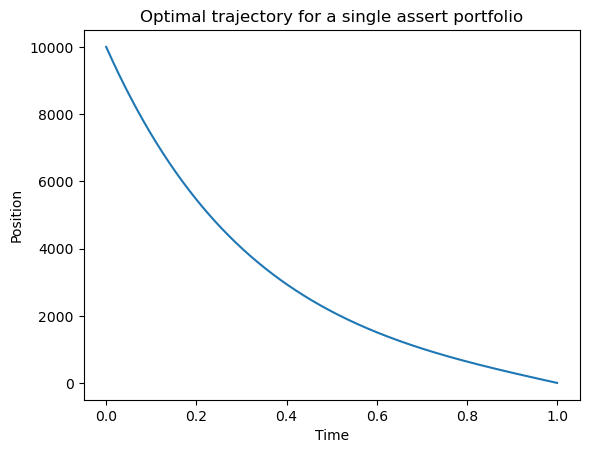

In [34]:
gamma_ex = 10**(-5)
eta_ex = 10**(-4)
sigma_ex = 30
lamda_ex = 10**(-6)

x_strategy = algrem_chriss(X, gamma_ex, eta_ex, sigma_ex, lamda_ex, N, T)

plt.plot(time, x_strategy)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Optimal trajectory for a single assert portfolio')
plt.show()

# Sensitivity
## with regard to $\lambda$ - risk aversion parameter

/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_39840/4163704716.py:12: RuntimeWarning: overflow encountered in sinh
  x_j = (np.sinh(K*(T-t_j)) / np.sinh(K*T)) * X
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_39840/4163704716.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_j = (np.sinh(K*(T-t_j)) / np.sinh(K*T)) * X


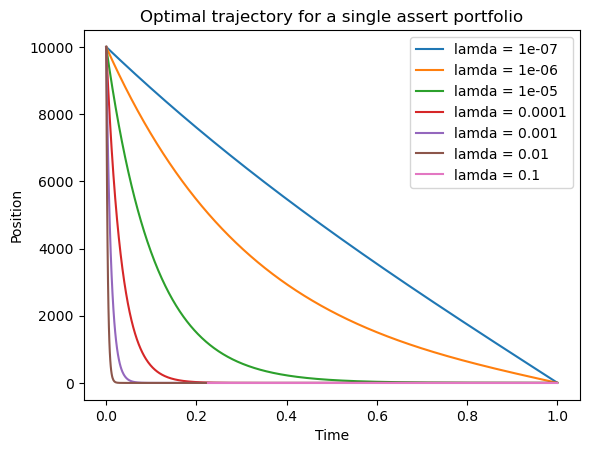

In [41]:
lamda_list = [10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]

for lamda in lamda_list:
    x_strategy = algrem_chriss(X, gamma_ex, eta_ex, sigma_ex, lamda, N, T)

    plt.plot(time, x_strategy, label = 'lamda = {}'.format(lamda))
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Optimal trajectory for a single assert portfolio')
plt.legend()
plt.show()

- If $\lambda$ converges to 0, then our cost of liquidation is reduced to the expected part and tend to the regular naive strategy
- If $\lambda$ converges to $\infty$, then the strategy tend to the naive strategy where we sell evrything at $t_0$. Indeed it corresponds perfectly tp a high risk aversion. 

## with regard to $\gamma$ - permanent market impact parameter

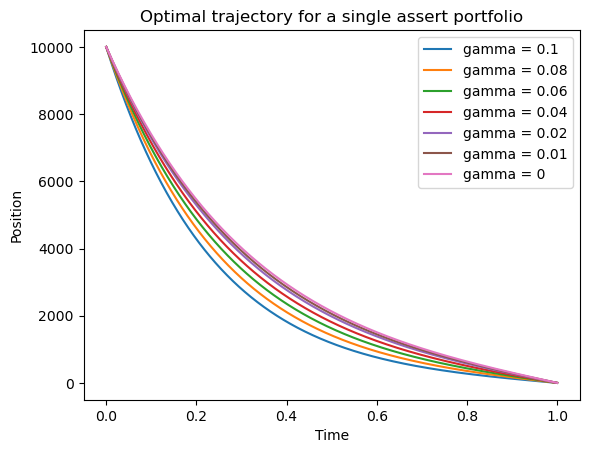

In [47]:
gamma_list = [0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0]

for gamma in gamma_list:
    x_strategy = algrem_chriss(X, gamma, eta_ex, sigma_ex, lamda_ex, N, T)

    plt.plot(time, x_strategy, label = 'gamma = {}'.format(gamma))
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Optimal trajectory for a single assert portfolio')
plt.legend()
plt.show()

if $\gamma$ increases, then the strategy tend to sell more stock at the beginning of the day. Indeed, holding the asset will increase the cost to the permanent decrease of the price du to the permanent impact 

## with regard to $\eta$ - temporary market impact parameter

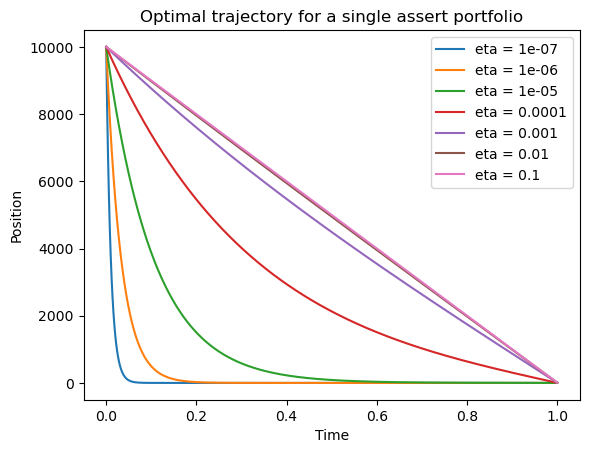

In [42]:
eta_list = [10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]

for eta in eta_list:
    x_strategy = algrem_chriss(X, gamma_ex, eta, sigma_ex, lamda_ex, N, T)

    plt.plot(time, x_strategy, label = 'eta = {}'.format(eta))
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Optimal trajectory for a single assert portfolio')
plt.legend()
plt.show()

- if $\eta$ converges to $0$, then the temporary market impact is very low, which means selling big quantities does not decrease the pure benefice of it. The strategy converges to selling everything at $t_0$ because it avoid the volatility risk 
- if $\eta$ converges to $\infty$, then the temporary market impact is very very high, which means selling big quantities increase a lot the loss du to big selling. So the strategy tends to the regular one

# Conclusion

The Almgen and Chriss algorithm allows us to liquidate or build a portfolio. It can be adapt to a portfolio containing different assets which are correlated. It determines the optimal strategy with respect to the risk aversion the trader wants. 

However, this algorithm does not provide information about how we should sell (or buy following our aim) between the times $t_k$ (periods of 5-10 min as it is an intraday algorithm)